`IMPORTANTE`: Esse é um caso real de clusterização de profissionais para uma multinacional. Os dados foram transformados para garantir o sigilo do cliente.

Optei por esse projeto por ele trazer algo que não é usualmente pedido: uma clusterização com alguns "direcionamentos". Para isso usei a biblioteca KMeansConstrained (pip install k-means-constrained).

In [1]:
# Importar bibliotecas necessárias
from sklearn.preprocessing import StandardScaler
from k_means_constrained import KMeansConstrained
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import seaborn as sns
sns.reset_defaults()
sns.set(rc={'figure.figsize':(7,5)}, style="white")

In [2]:
data = pd.read_csv('clustering_sample.csv')
data.head(3)

,uf,profissional,metrica_1,metrica_2
0,AC,b'gAAAAABlvSCBv6YBS0MVX0gpj_lZ46VDWNenGzIIiuut...,1,0
1,AL,b'gAAAAABlvSCBDCUtuNfCCfcVKz5fa41fJViPAaEPXikX...,7,9
2,AL,b'gAAAAABlvSCBTYTi1NWF8BB25BTHBKRmYLvJB7ZyBpK4...,8,6


`CLUSTERIZAÇÃO`: **vale mencionar que os dados foram encriptados e alterados de forma aleatória e isso poderá trazer resultados estranhos**

Use apenas a ideia do código, em especial a parte de ordenar as letras do clusters e garantir que os intervalos não se sobreponham...rs.

Antes desse código foi feito todo um processo de extração, análise e pré-processamento dos dados que não fazem sentido colocar aqui.

In [3]:
# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[['metrica_1', 'metrica_2']])

# Define the maximum size for the largest cluster
max_largest_cluster_size = 0.35

# Apply K-Means constrained clustering
kmeans = KMeansConstrained(n_clusters=4, size_min=1, size_max=int(max_largest_cluster_size * len(data)))
data['Cluster'] = kmeans.fit_predict(data_scaled)

# Create a summary table with aggregated metrics for each cluster
mapear_cluster = data.groupby('Cluster').agg({'metrica_2':'max','profissional':'nunique'}).rename(columns={'profissional':'qtd_medicos'}).reset_index()

# Sort the summary table by 'metrica_2' in descending order
mapear_cluster = mapear_cluster.sort_values(by='metrica_2', ascending=False)

# Create a mapping of cluster labels to letters (A to D)
unique_clusters = mapear_cluster['Cluster'].unique()
cluster_order = {cluster: chr(65 + i) for i, cluster in enumerate(unique_clusters)}

# Map the 'Cluster' column to letters based on the order of clusters
mapear_cluster['cluster_letter'] = mapear_cluster['Cluster'].map(cluster_order)

# Create a new DataFrame with relevant cluster information
mapear_cluster = mapear_cluster[['Cluster', 'cluster_letter']]

# Merge the cluster information back into the original data
data = data.merge(mapear_cluster, on='Cluster', how='left')

In [4]:
# Create a summary table 'cluster_' with aggregated metrics for each cluster letter
cluster_ = data.groupby('cluster_letter').agg({'metrica_2':['min','max'], 'profissional':'nunique'}).rename(columns={'profissional':'qtd_profissionais'})

# Flatten the multi-level column index for better readability
cluster_.columns = cluster_.columns.map('{0[0]}_{0[1]}'.format)

# Reset the index and rename columns for clarity
cluster_ = cluster_.rename_axis(index=None).reset_index()
cluster_.rename(columns={'metrica_2_min':'cluster_min','metrica_2_max':'cluster_max', 'index':'cluster_letter'}, inplace=True)

# Extract relevant columns ('cluster_letter', 'cluster_min', 'cluster_max') for further use
cluster_ = cluster_[['cluster_letter', 'cluster_min', 'cluster_max']]

# Merge the 'cluster_' information back into the original data using 'cluster_letter'
data = data.merge(cluster_, on='cluster_letter', how='inner')

In [5]:
# Further processing to adjust minimum cluster sizes based on specific conditions
data.loc[data['cluster_letter'] == 'D', 'cluster_min'] = 1
data.loc[data['cluster_letter'] == 'C', 'cluster_min'] = data.loc[data['cluster_letter'] == 'D', 'cluster_max'].values[0] + 1
data.loc[data['cluster_letter'] == 'B', 'cluster_min'] = data.loc[data['cluster_letter'] == 'C', 'cluster_max'].values[0] + 1
data.loc[data['cluster_letter'] == 'A', 'cluster_min'] = data.loc[data['cluster_letter'] == 'B', 'cluster_max'].values[0] + 1

# Display a summary table with the maximum and unique counts of professionals in each cluster
display(data.groupby(['cluster_letter']).agg({'cluster_min':'max','cluster_max':'max', 'profissional':'nunique'}))

,cluster_min,cluster_max,profissional
cluster_letter,,,
A,63,99,146
B,10,62,339
C,7,9,563
D,1,6,563


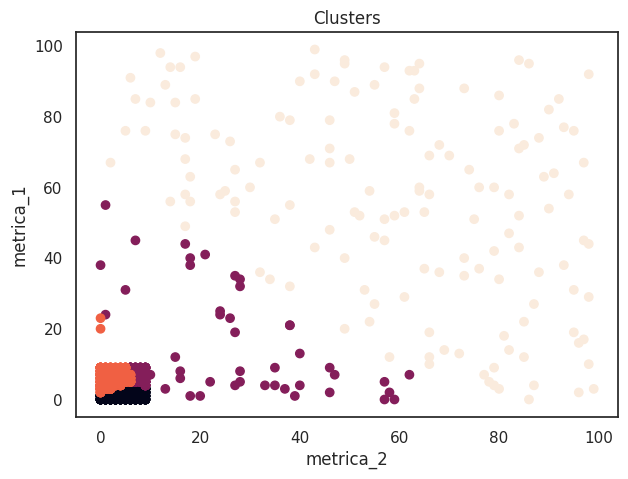

In [6]:
# Visualize the clusters with a scatter plot
plt.scatter(data['metrica_2'], data['metrica_1'], c=data['Cluster'])
plt.title('Clusters')
plt.xlabel('metrica_2')
plt.ylabel('metrica_1')
plt.show()